In [127]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import sys
from scipy import constants

### Preprocessing

In [128]:

Eqf = lambda l, I: 10 * constants.pi * I * l * constants.nano / (constants.h * constants.c * constants.Avogadro * constants.micro) # [umol/m2s = muE]

print("Q from W/m2 for 555nm and 200W/m2: ", Eqf(555, 200))
print("Q from W/m2 for 555nm and 800W/m2: ", Eqf(555, 800))
print("Q from W/m2 for 555nm and 1000W/m2: ", Eqf(555, 1000))
print("Q from W/m2 for 555nm and 1200W/m2: ", Eqf(555, 1200))
print("Q from W/m2 for 555nm and 1400W/m2: ", Eqf(555, 1400))

Q from W/m2 for 555nm and 200W/m2:  29150.44686659997
Q from W/m2 for 555nm and 800W/m2:  116601.78746639988
Q from W/m2 for 555nm and 1000W/m2:  145752.23433299985
Q from W/m2 for 555nm and 1200W/m2:  174902.68119959984
Q from W/m2 for 555nm and 1400W/m2:  204053.1280661998


In [129]:
filename = "output_*.csv"
files = glob.glob(filename)
# take newest file
files.sort(key=os.path.getmtime)
filename = files[-1]
print("Reading file: ", filename)

Reading file:  output_1724230496551.csv


In [130]:
data = pd.read_csv(filename)
data = data.dropna()
# columns time is a string in format %Y.%m.%d-%H:%M:%S
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%Y.%m.%d-%H:%M:%S')
# make the time the index
data.set_index('Timestamp', inplace=True)
# make time local
data.index = data.index.tz_localize('UTC').tz_convert('Europe/Stockholm')
# remove unnamed columns
data = data.loc[:, ~data.columns.str.contains('^idx')]
# extract start timestamp from first line in file

In [131]:
# print columns and their types and starting values
print(data.dtypes)
print(data.head())


plant [#]             int64
light [Q]           float64
Flux [cm3/day]      float64
An [umol/m2/s]      float64
Vc [umol/m2/s]      float64
Vj [umol/m2/s]      float64
gco2 [umol/m2/s]    float64
cics [-]            float64
fw [-]              float64
dtype: object
                           plant [#]   light [Q]  Flux [cm3/day]  \
Timestamp                                                          
2019-06-01 05:42:00+02:00          0   696.41327    3.796413e-07   
2019-06-01 05:48:00+02:00          0  1109.72070    3.727283e-07   
2019-06-01 05:54:00+02:00          0   285.35678    3.734547e-07   
2019-06-01 06:00:00+02:00          0   831.49710    3.734462e-07   
2019-06-01 06:06:00+02:00          0   592.39856    3.848229e-07   

                           An [umol/m2/s]  Vc [umol/m2/s]  Vj [umol/m2/s]  \
Timestamp                                                                   
2019-06-01 05:42:00+02:00       -0.226325        6.487081             0.0   
2019-06-01 05:48:00+02:00 

### General Plots

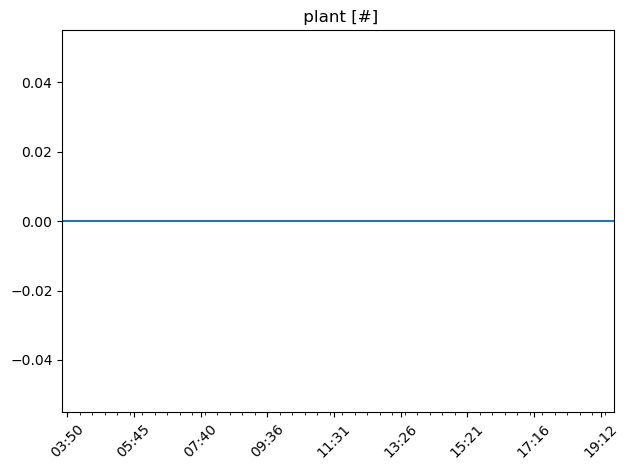

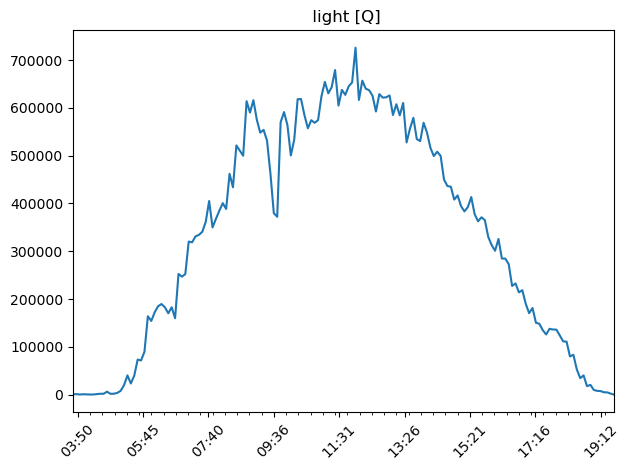

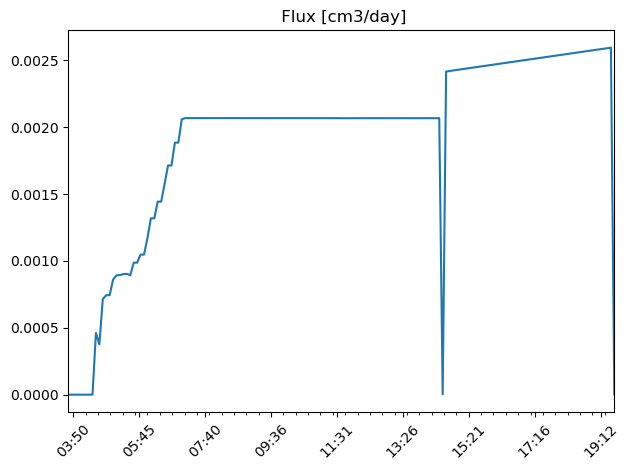

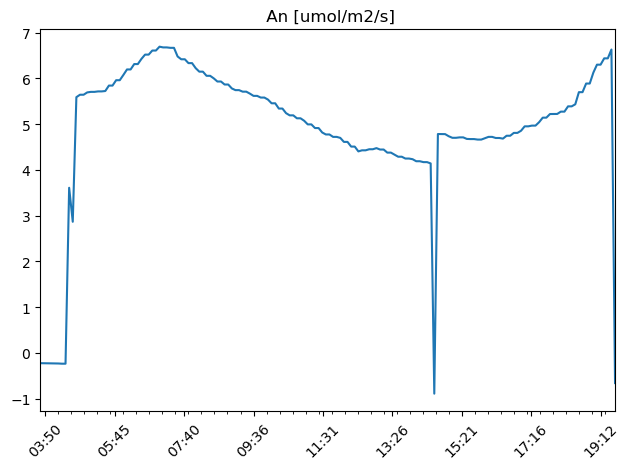

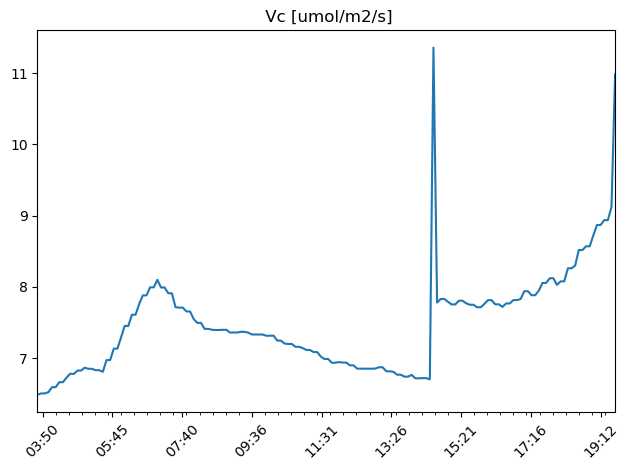

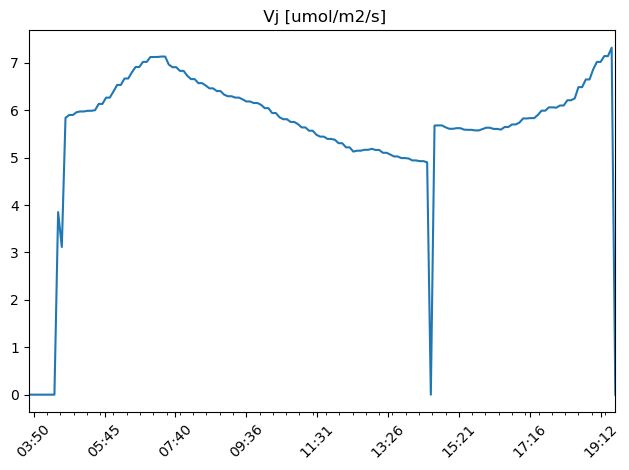

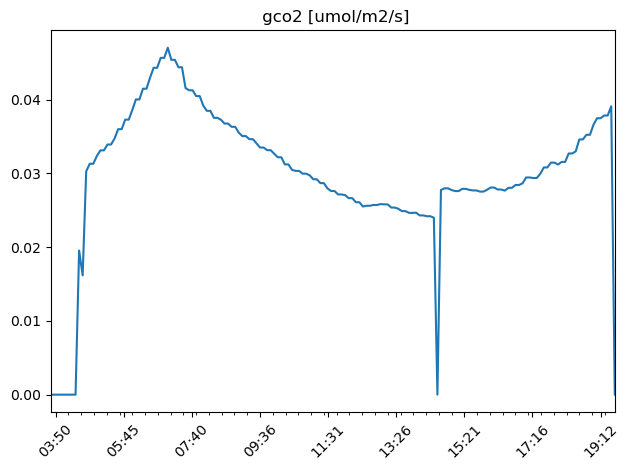

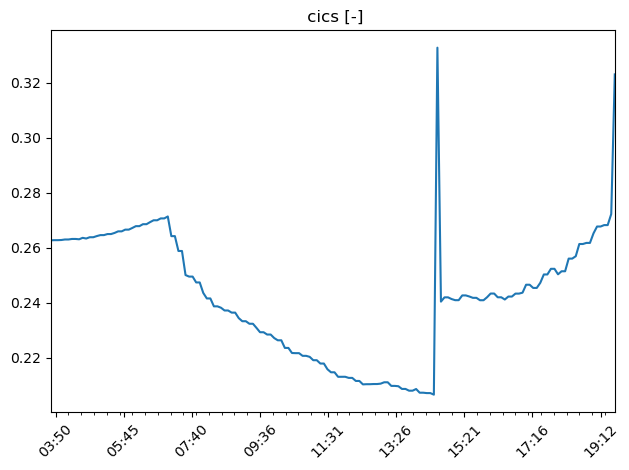

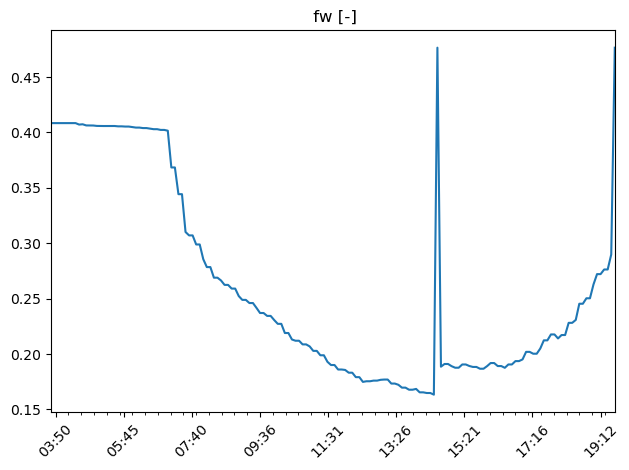

In [132]:
import matplotlib.dates as mdates
for c in data.columns :
  # plot all data as a start
  fig, ax = plt.subplots()
  ax.plot(data.index, data[c])
  # xticks with time and date if data changed
  plt.xticks(rotation=45)
  plt.tight_layout()
  # set xlim to the data
  ax.set_xlim(data.index[0], data.index[-1])
  # show hour and minutes on x-axis
  ax.xaxis.set_major_locator(plt.MaxNLocator(10))
  ax.xaxis.set_minor_locator(plt.MaxNLocator(60))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
  # set ylim to the data
  day = -1
  ax.set_title(c)
  plt.tight_layout()
  plt.show()

In [133]:
# add the selhausen data for overlay
filename = "SE_EC_001.1711883710395.csv"
with open ("SE_EC_001.1711883710395.csv", "r") as f :
  # get line 93
  for i in range(92) :
    f.readline()
  # get the column data
  line = f.readline()[1:]
  line = [c.strip() for c in line.split(",")]
  columns = line
# endwith
seldata = pd.read_csv("SE_EC_001.1711883710395.csv", skiprows = 93, names = columns)
for col in seldata.columns:
  if "QualityFlag" in col:
    seldata[col] = seldata[col].str.split("_", expand=True)[1]
    # convert the values to numeric
    seldata[col] = pd.to_numeric(seldata[col], errors='coerce')
  # endif
# endfor
# exchange "noData" with NaN
seldata = seldata.replace("noData", np.nan)
# convert the time to datetime
seldata["Time"] = pd.to_datetime(seldata["Time"], format="%Y-%m-%dT%H:%M:%S%z")
seldata = seldata.set_index("Time")
quality_flags = data.filter(like="QualityFlag")
seldata = seldata.drop(columns = quality_flags.columns)
seldata = seldata.drop(columns="feature")
seldata = seldata.apply(pd.to_numeric, errors='coerce')
seldata.sort_index(inplace=True)
seldata.index = pd.to_datetime(seldata.index, format="%Y-%m-%dT%H:%M:%S%z", utc=True)
quality_flags.index = seldata.index
seldata = seldata.asfreq("10T")
quality_flags = quality_flags.asfreq("10T")
seldata.fillna(method="interpolate", inplace=True)

/tmp/ipykernel_23690/628410830.py:12: DtypeWarning: Columns (26,32,38,52,54,56,58,60,62,64,66,68,70,72,74,76,78,80) have mixed types. Specify dtype option on import or set low_memory=False.
  seldata = pd.read_csv("SE_EC_001.1711883710395.csv", skiprows = 93, names = columns)
/tmp/ipykernel_23690/628410830.py:23: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  seldata["Time"] = pd.to_datetime(seldata["Time"], format="%Y-%m-%dT%H:%M:%S%z")
/tmp/ipykernel_23690/628410830.py:32: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  seldata = seldata.asfreq("10T")
/tmp/ipykernel_23690/628410830.py:33: FutureWarning: 'T' is deprecated and will be removed in a future version,

ValueError: Invalid fill method. Expecting pad (ffill) or backfill (bfill). Got interpolate

In [ ]:
# filter selhausen data such that indices are the same
seldata = seldata.loc[data.index[0]:data.index[-1]]
# make sure that indices are the same
seldata = seldata.reindex(data.index, method='nearest')

In [ ]:
def column_like(data, like):
  lower = like.lower()
  for c in data.columns:
    if lower in c.lower():
      return c
  return None
# enddef

airtemp_c = column_like(seldata, "AirTemp")
print(airtemp_c)


AirTemperature_2m_Avg10min_Sensor1 [°C]


/tmp/ipykernel_23690/1752898744.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_23690/1752898744.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


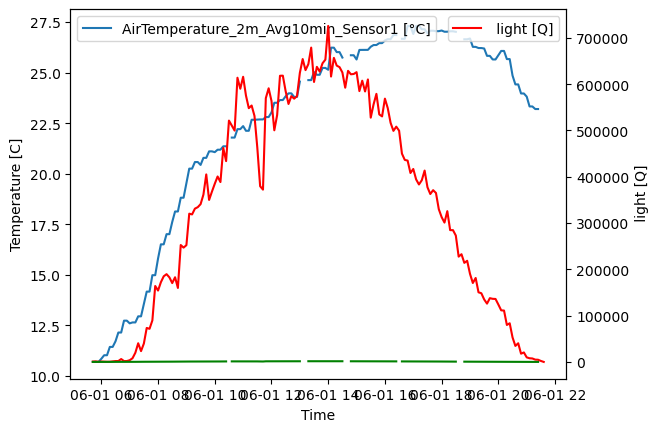

In [ ]:
# plot temperature(seldata), PAR(seldata), and Q(data)
fig, ax = plt.subplots()
ax.plot(seldata.index, seldata[airtemp_c], label=airtemp_c)
ax.set_ylabel("Temperature [C]")
ax.set_xlabel("Time")
ax.legend(loc="upper left")
ax2 = ax.twinx()
ax2.plot(data.index, data[column_like(data, "light")], label=column_like(data, "light"), color="red")
ax2.set_ylabel(column_like(data, "light"))
ax2.legend(loc="upper right")
c = column_like(seldata, "RadiationPhotosyntheticActive_2m_Avg10min")
ax2.plot(data.index, seldata[c], label=c, color="green")
# 45 degree axis label
# get the axes
ax = plt.gca()
for tick in ax.get_xticklabels():
  tick.set_rotation(45)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
fig.show()

In [ ]:
seldata.head()

,AirConcentration_CO2_2m_Avg30min [mmol*m-3],AirConcentration_CO2_2m_Avg30minQualityFlag,AirFlux_CO2_Avg30min_BelowObsHeight [umol*m-2*s-1],AirFlux_CO2_Avg30min_BelowObsHeightQualityFlag,AirFlux_CO2_Avg30min_NetExchange [umol*m-2*s-1],AirFlux_CO2_Avg30min_NetExchangeQualityFlag,AirFlux_CO2_RelErrNoise [%],AirFlux_CO2_RelErrNoiseQualityFlag,AirFlux_CO2_RelErrRandom [%],AirFlux_CO2_RelErrRandomQualityFlag,...,WindDirection_2.52m_Avg10minQualityFlag,WindDirection_38m_Avg30min [°N],WindDirection_38m_Avg30minQualityFlag,WindFrictionVelocity [m*s-1],WindFrictionVelocityQualityFlag,WindSpeed_2m_Avg10min [m*s-1],WindSpeed_2m_Avg10minQualityFlag,WindSpeed_2m_Avg30min [m*s-1],WindSpeed_2m_Avg30minQualityFlag,
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-01 05:42:00+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2002.0,NaN,NaN,NaN,NaN,0.448754,2002.0,NaN,NaN,NaN
2019-06-01 05:48:00+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2002.0,NaN,NaN,NaN,NaN,0.448754,2002.0,NaN,NaN,NaN
2019-06-01 05:54:00+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2002.0,NaN,NaN,NaN,NaN,0.448754,2002.0,NaN,NaN,NaN
2019-06-01 06:00:00+02:00,22.173492,2025.0,-0.3135,2025.0,1.4265,2025.0,1.266427,2025.0,26.753874,2025.0,...,2002.0,108.31253,2025.0,0.0534,2025.0,0.397907,2002.0,0.450812,2025.0,NaN
2019-06-01 06:06:00+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2002.0,NaN,NaN,NaN,NaN,0.184937,2002.0,NaN,NaN,NaN
